## Baseline
---

In [1]:
import json, sys, os

sys.path.insert(1, "../..")
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns
import smart_open

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_modeling_df_refit.parquet')
test_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_test_df_refit.parquet')

In [3]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [4]:
target_col = "is_returned"
pred_cols = ['deposit_v1_pred', 'customer_pred', 'score']
metrics = get_pred_reports(test_df, target_col, pred_cols)
metrics

,auc,ap,ks
deposit_v1_pred,81.51,21.61,49.30
customer_pred,85.08,30.23,55.74
score,89.58,44.59,64.56


(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

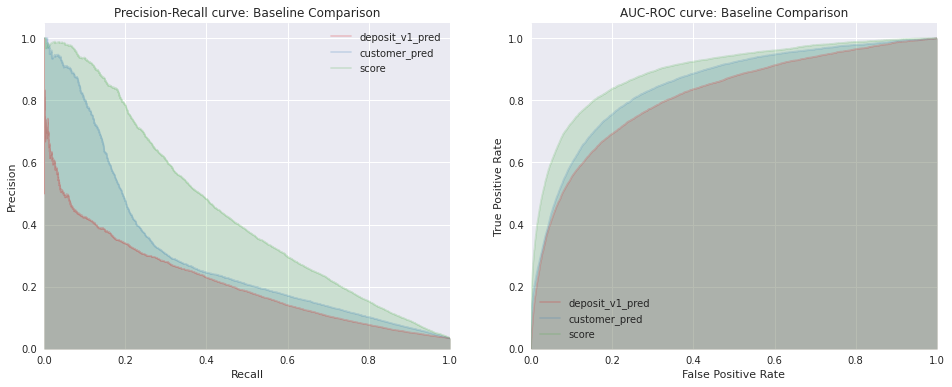

In [5]:
preds = [(test_df[col], col) for col in pred_cols]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

<AxesSubplot:>

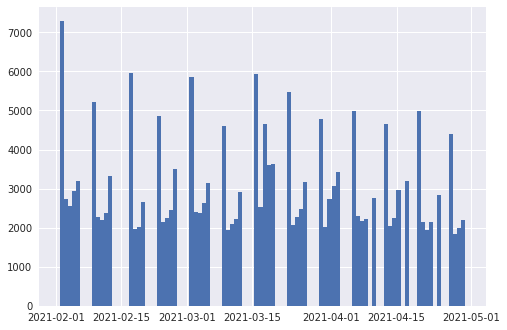

In [6]:
test_df.transaction_datetime.hist(bins=100)

========= month: 2 =========


,auc,ap,ks
deposit_v1_pred,80.90,19.91,48.32
customer_pred,85.80,31.20,57.03
score,90.06,44.22,65.28


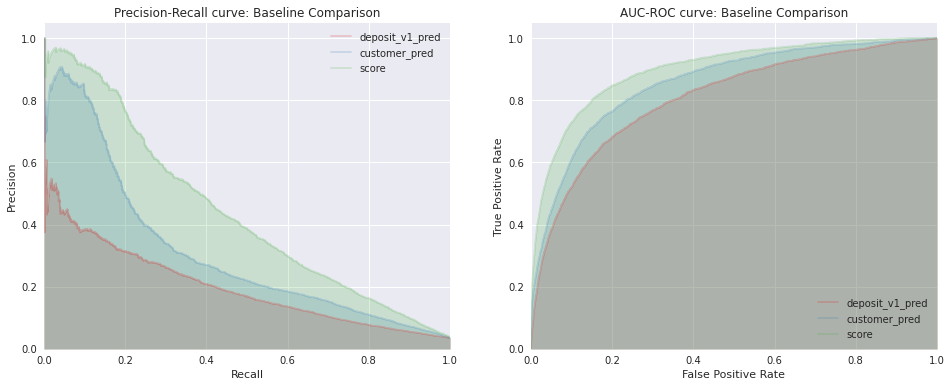

========= month: 3 =========


,auc,ap,ks
deposit_v1_pred,81.88,23.40,49.96
customer_pred,85.03,29.51,55.99
score,89.56,44.24,64.44


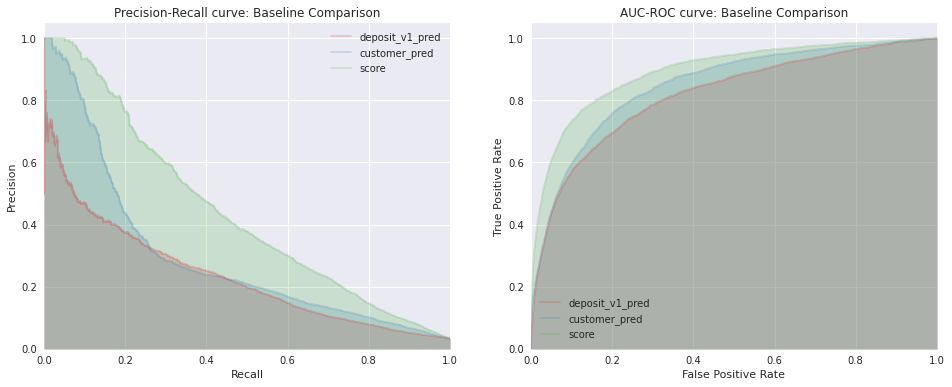

========= month: 4 =========


,auc,ap,ks
deposit_v1_pred,81.70,21.59,50.21
customer_pred,84.45,31.26,54.56
score,89.13,45.83,64.46


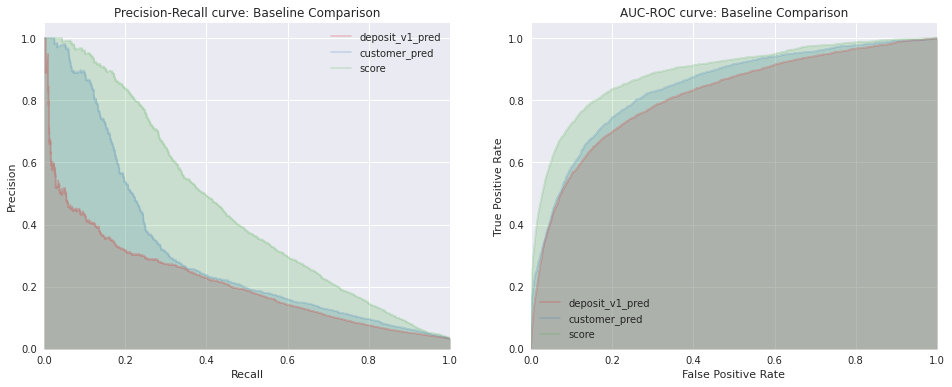

In [9]:
for m in test_df.transaction_datetime.dt.month.unique():
    print(f"========= month: {m} =========")
    test_df_ = test_df[test_df.transaction_datetime.dt.month == m]
    preds = [(test_df_[col], col) for col in pred_cols]
    targets = test_df_[target_col]

    metrics = get_pred_reports(test_df_, target_col, pred_cols)
    display(metrics)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

    title = 'Precision-Recall curve: Baseline Comparison'
    plot_pr_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[0], fig=fig) 

    title = 'AUC-ROC curve: Baseline Comparison'
    plot_auc_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[1], fig=fig)
    plt.show()